In [25]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from src.preprocess import preprocess_folder
from src.format_data import create_dataset
from src.model import create_embedding_model, create_flux_model
from src.losses import get_companion_std, keep_back

from tensorflow.keras.optimizers import Adam
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
cube, psf, rot_angles, table = preprocess_folder(root='./data/fake', 
												 target_folder='./data/fake/preprocessed')

table = table[table['snr'] > 3]
window_size = 30
dataset = create_dataset(cube, psf, rot_angles, table, window_size=window_size,
                         batch_size=2000, repeat=2)

model = create_embedding_model(window_size=window_size)

optimizer = Adam(1e-5)
model.compile(loss_fn=keep_back, optimizer=optimizer)

es = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        min_delta=1e-6,
        patience=50,
        mode='min',
        restore_best_weights=True,
    )

[INFO] Restoring saved values


In [27]:
# model.summary()
table

,x,y,flux,fwhm_mean,snr
0,386.000008,727.508451,137.76877,4.946172,80.595763


In [28]:
%%time
hist = model.fit(dataset, epochs=10000, callbacks=[es])

Epoch 1/10000
1/1 [==============================] - 2s 2s/step - loss: 0.4575
Epoch 2/10000
1/1 [==============================] - 0s 129ms/step - loss: 0.4575
Epoch 3/10000
1/1 [==============================] - 0s 92ms/step - loss: 0.4575
Epoch 4/10000
1/1 [==============================] - 0s 98ms/step - loss: 0.4575
Epoch 5/10000
1/1 [==============================] - 0s 76ms/step - loss: 0.4575
Epoch 6/10000
1/1 [==============================] - 0s 97ms/step - loss: 0.4575
Epoch 7/10000
1/1 [==============================] - 0s 89ms/step - loss: 0.4574
Epoch 8/10000
1/1 [==============================] - 0s 96ms/step - loss: 0.4574
Epoch 9/10000
1/1 [==============================] - 0s 82ms/step - loss: 0.4574
Epoch 10/10000
1/1 [==============================] - 0s 80ms/step - loss: 0.4574
Epoch 11/10000
1/1 [==============================] - 0s 78ms/step - loss: 0.4574
Epoch 12/10000
1/1 [==============================] - 0s 75ms/step - loss: 0.4574
Epoch 13/10000
1/1 [======

1/1 [==============================] - 0s 102ms/step - loss: 0.4564
Epoch 101/10000
1/1 [==============================] - 0s 86ms/step - loss: 0.4564
Epoch 102/10000
1/1 [==============================] - 0s 82ms/step - loss: 0.4564
Epoch 103/10000
1/1 [==============================] - 0s 87ms/step - loss: 0.4564
Epoch 104/10000
1/1 [==============================] - 0s 93ms/step - loss: 0.4563
Epoch 105/10000
1/1 [==============================] - 0s 80ms/step - loss: 0.4563
Epoch 106/10000
1/1 [==============================] - 0s 75ms/step - loss: 0.4563
Epoch 107/10000
1/1 [==============================] - 0s 101ms/step - loss: 0.4563
Epoch 108/10000
1/1 [==============================] - 0s 103ms/step - loss: 0.4563
Epoch 109/10000
1/1 [==============================] - 0s 93ms/step - loss: 0.4562
Epoch 110/10000
1/1 [==============================] - 0s 127ms/step - loss: 0.4562
Epoch 111/10000
1/1 [==============================] - 0s 85ms/step - loss: 0.4562
Epoch 112/10000


1/1 [==============================] - 0s 77ms/step - loss: 0.4542
Epoch 199/10000
1/1 [==============================] - 0s 74ms/step - loss: 0.4542
Epoch 200/10000
1/1 [==============================] - 0s 79ms/step - loss: 0.4542
Epoch 201/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.4541
Epoch 202/10000
1/1 [==============================] - 0s 87ms/step - loss: 0.4541
Epoch 203/10000
1/1 [==============================] - 0s 82ms/step - loss: 0.4541
Epoch 204/10000
1/1 [==============================] - 0s 89ms/step - loss: 0.4541
Epoch 205/10000
1/1 [==============================] - 0s 79ms/step - loss: 0.4541
Epoch 206/10000
1/1 [==============================] - 0s 76ms/step - loss: 0.4541
Epoch 207/10000
1/1 [==============================] - 0s 83ms/step - loss: 0.4541
Epoch 208/10000
1/1 [==============================] - 0s 79ms/step - loss: 0.4541
Epoch 209/10000
1/1 [==============================] - 0s 75ms/step - loss: 0.4541
Epoch 210/10000
1/1 

1/1 [==============================] - 0s 91ms/step - loss: 0.4540
CPU times: user 15min 53s, sys: 9min 12s, total: 25min 6s
Wall time: 30.3 s


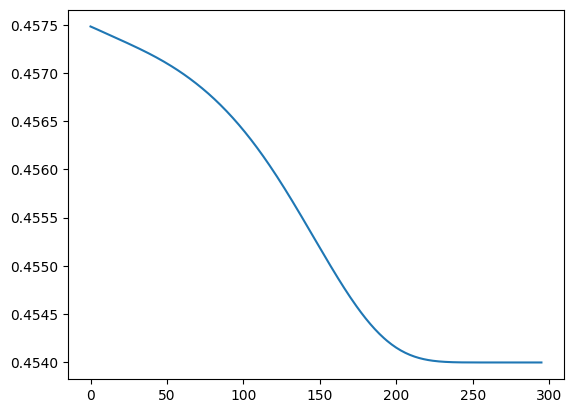

In [29]:
plt.plot(hist.history['loss'])

In [30]:
test_ds = create_dataset(cube, psf, rot_angles, table, window_size=window_size, batch_size=2000, repeat=1)

In [31]:
pred, flux = model.predict(test_ds)

2/2 [==============================] - 1s 9ms/step


In [40]:
np.mean(flux[-1])
tf.reduce_max(flux[-1], axis=[1,2,3])

<tf.Tensor: shape=(80,), dtype=float32, numpy=
array([148.47377, 148.47377, 148.47377, 148.47377, 148.47377, 148.47377,
       148.47377, 148.47377, 148.47377, 148.47377, 148.47377, 148.47377,
       148.47377, 148.47377, 148.47377, 148.47377, 148.47377, 148.47377,
       148.47377, 148.47377, 148.47377, 148.47377, 148.47377, 148.47377,
       148.47377, 148.47377, 148.47377, 148.47377, 148.47377, 148.47377,
       148.47377, 148.47377, 148.47377, 148.47377, 148.47377, 148.47377,
       148.47377, 148.47377, 148.47377, 148.47377, 148.50032, 148.50032,
       148.50032, 148.50032, 148.50032, 148.50032, 148.50032, 148.50032,
       148.50032, 148.50032, 148.50032, 148.50032, 148.50032, 148.50032,
       148.50032, 148.50032, 148.50032, 148.50032, 148.50032, 148.50032,
       148.50032, 148.50032, 148.50032, 148.50032, 148.50032, 148.50032,
       148.50032, 148.50032, 148.50032, 148.50032, 148.50032, 148.50032,
       148.50032, 148.50032, 148.50032, 148.50032, 148.50032, 148.50032,
    

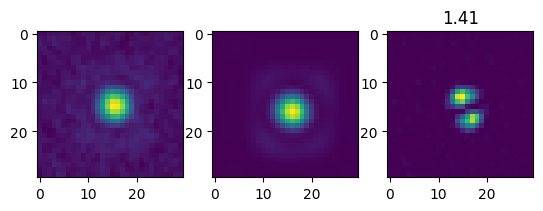

In [41]:
fig, axes = plt.subplots(1, 3)

for x, y in test_ds:
    n = 10

    win_0 = x['windows'][n]
    win_1 = pred[n]
    
    axes[0].imshow(win_0)
    axes[1].imshow(win_1)
    residuals = tf.math.subtract(win_0, win_1)

    res_square = tf.pow(residuals, 2)
    axes[2].set_title('{:.2f}'.format(tf.math.reduce_std(res_square)))
    axes[2].imshow(res_square)
    break
    
plt.show()

In [146]:
def create_circle_decay_matrix(width, height, power=3):
    # Calculate the center coordinates
    center_x = (width - 1) / 2
    center_y = (height - 1) / 2

    # Generate grid points for x and y coordinates
    x = tf.linspace(0.0, width - 1, width)
    y = tf.linspace(0.0, height - 1, height)
    x_grid, y_grid = tf.meshgrid(x, y)

    # Calculate the Euclidean distance from each point to the center
    distances = tf.sqrt(tf.square(x_grid - center_x) + tf.square(y_grid - center_y))

    # Calculate the maximum distance from the center
    max_distance = tf.sqrt(tf.square(center_x) + tf.square(center_y))

    # Normalize the distances to the range [0, 1]
    normalized_distances = distances / max_distance

    # Apply a non-linear transformation for faster decay
    decay_matrix = tf.pow(1 - normalized_distances, power)

    return decay_matrix

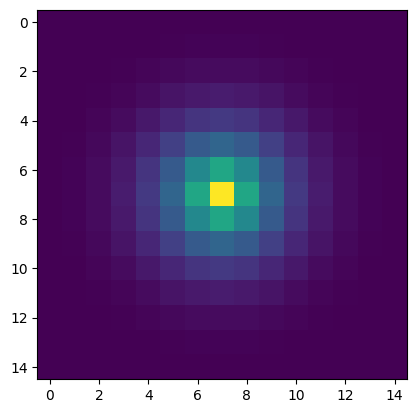

In [155]:
random = create_circle_decay_matrix(15, 15, table['fwhm_mean'].values[0])
plt.imshow(random)

In [154]:
table['fwhm_mean'].values[0]

4.946171742401174